# CNN Classifier Training Example

This notebook demonstrates a basic 4-layer CNN trained to classify spectra from galaxies and galaxies + KNe or SNe of several types and within 2 weeks (plus/minus) of max light. In this notebook the classifier assumes we can work in the host rest frame.

Required software:
* TensorFlow2
* [desihub software](https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop) (with usual dependencies).

Adding more spectral categories is straightforward.

In [1]:
from desispec.io import read_spectra
from desitrip.preproc import rebin_flux, rescale_flux

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow
from joblib import Parallel, delayed

from astropy.table import Table

import os
import platform

mpl.rc('font', size=14)

## Input Spectra

Input DESI spectra, rebin and rescale them, and then divide them into training and test sets for the classifier.

In [2]:
def condition_spectra(coadd_files, truth_files):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    coadd_files : list or ndarray
        List of FITS files on disk with DESI spectra.
    truth_files : list or ndarray
        Truth files.
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = None
    
    for cf, tf in zip(coadd_files, truth_files):
        spectra = read_spectra(cf)
        wave = spectra.wave['brz']
        flux = spectra.flux['brz']
        ivar = spectra.ivar['brz']
        
        truth = Table.read(tf, 'TRUTH')
        try:
            truez = truth['TRUEZ']
        except:
            print(truth)
            print(cf, tf)

#         # Pre-condition: remove spectra with NaNs and zero flux values.
#         mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
#         mask_idx = np.argwhere(mask)
#         flux = np.delete(flux, mask_idx, axis=0)
#         ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, truez, minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
        rsflux = rescale_flux(reflux)

        if fluxes is None:
            fluxes = rsflux
        else:
            fluxes = np.concatenate((fluxes, rsflux))
    
    return fluxes

In [3]:
path_to_bgs = '/global/cfs/cdirs/desi/science/td/sim/bgs'

In [4]:
host_truth = sorted(glob('{}/150s/hosts/*truth.fits'.format(path_to_bgs)))
host_coadd = sorted(glob('{}/150s/hosts/*coadd.fits'.format(path_to_bgs)))
host_flux  = condition_spectra(host_coadd, host_truth)
# this cell takes approximately 1min23sec

In [5]:
snia_truth = sorted(glob('{}/150s/sn_ia/hsiao/*truth.fits'.format(path_to_bgs)))
snia_files = sorted(glob('{}/150s/sn_ia/hsiao/*coadd.fits'.format(path_to_bgs)))
snia_flux  = condition_spectra(snia_files, snia_truth)

In [6]:
sniip_truth = sorted(glob('{}/150s/sn_iip/*/*truth.fits'.format(path_to_bgs)))
sniip_files = sorted(glob('{}/150s/sn_iip/*/*coadd.fits'.format(path_to_bgs)))
sniip_flux  = condition_spectra(sniip_files, sniip_truth)

In [7]:
kn_truth = sorted(glob('{}/180s/kn/*/*/*truth.fits'.format(path_to_bgs)))
kn_files = sorted(glob('{}/180s/kn/*/*/*coadd.fits'.format(path_to_bgs)))

In [16]:
def condition_parallel(njobs, files, truth):
    all_files = np.array_split(files, njobs)
    all_truth = np.array_split(truth, njobs)
    return Parallel(n_jobs=njobs)(delayed(condition_spectra)(all_files[i], all_truth[j]) for i, j in zip(range(njobs), range(njobs)))

flux = condition_parallel(12, kn_files, kn_truth)

12


In [25]:
kn_array = np.array(flux)
fluxes = None

for n in range(12):
    if fluxes is None:
        fluxes = kn_array[1]
    else:
        fluxes = np.concatenate((fluxes, kn_array[n]))
            
kn_flux = fluxes

In [33]:
print('kn_truth len: {}'.format((len(kn_truth))))
print('snia_truth len: {}'.format(len(snia_truth)))
print('kn_files len: {}'.format(len(kn_files)))
print('snia_files len: {}'.format(len(snia_files)))
print('kn_flux len: {}'.format(len(kn_flux)))
print('snia_flux len: {}'.format(len(snia_flux)))

kn_truth len: 12047
snia_truth len: 100
kn_files len: 12047
snia_files len: 100
kn_flux len: 12010
snia_flux len: 9964


In [34]:
nhost, nbins  = host_flux.shape
nsnia, nbins  = snia_flux.shape
nsniip, nbins = sniip_flux.shape
nkn, nbins = kn_flux.shape
nhost, nsnia, nsniip, nkn, nbins

(9969, 9964, 9962, 12010, 150)

### Plot Spectra to Check Output

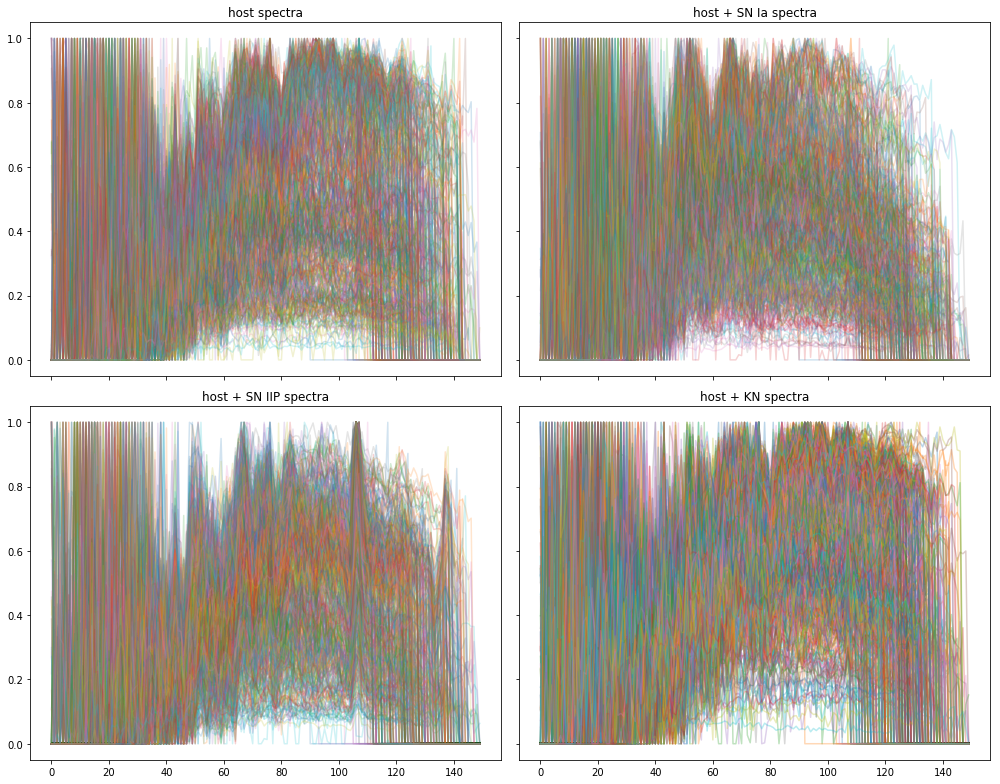

In [36]:
fig, axes = plt.subplots(2,2, figsize=(14,11), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(0,500):
    
    ax = axes[0]
    ax.plot(host_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
    ax = axes[2]
    ax.plot(sniip_flux[i], alpha=0.2)
    
    ax = axes[3]
    ax.plot(kn_flux[i], alpha=0.3)
    
axes[0].set_title('host spectra')
axes[1].set_title('host + SN Ia spectra')
axes[2].set_title('host + SN IIP spectra')
axes[3].set_title('host + KN spectra')

fig.tight_layout()

### Set up Training Sets and Labels

0. "host" spectra based only on BGS templates
0. "snia" spectra based on BGS + SN Ia templates
0. "sniip" spectra based on BGS + SN IIP templates
0. "kn" spectra based on BGS + KN template

In [37]:
x = np.concatenate([host_flux, 
                    snia_flux,
                    sniip_flux,
                    kn_flux
                   ]).reshape(-1, nbins, 1)

labels = ['Host',
          'SN Ia',
          'SN IIP',
          'KN']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(nhost, 0), 
                        np.full(nsnia, 1),
                        np.full(nsniip, 2),
                        np.full(nkn, 3)
                       ]))

In [38]:
x.shape, y.shape

((41905, 150, 1), (41905, 4))

## CNN Network Setup

Train network with TensorFlow+Keras.

In [39]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

import pydot
import graphviz

In [40]:
def network(input_shape, ncat, learning_rate=0.0005, reg=0.0032, dropout=0.7436, seed=None):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [41]:
model = network((nbins, 1), ncat=y.shape[1])

In [42]:
model.summary()

Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 8)            48        
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 8)            32        
_________________________________________________________________
activation (Activation)      (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 16)            64    

In [43]:
'''tf.keras.utils.plot_model(model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    )'''

'tf.keras.utils.plot_model(model,\n    to_file="model.png",\n    show_shapes=True,\n    show_layer_names=True,\n    rankdir="TB",\n    expand_nested=True,\n    dpi=96,\n    )'

## Train and Test

Split the data into training and testing (validation) samples and fit the network weights.

In [62]:
from sklearn.model_selection import train_test_split

batch = 32
epoch = 30
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
hist = model.fit(x_train, y_train, batch_size=batch, epochs=epoch, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/30
983/983 [==============================] - 18s 18ms/step - loss: 0.7312 - accuracy: 0.7653 - val_loss: 0.7581 - val_accuracy: 0.7485
Epoch 2/30
983/983 [==============================] - 17s 17ms/step - loss: 0.7200 - accuracy: 0.7693 - val_loss: 0.7305 - val_accuracy: 0.7598
Epoch 3/30
983/983 [==============================] - 16s 16ms/step - loss: 0.7166 - accuracy: 0.7675 - val_loss: 0.7639 - val_accuracy: 0.7421
Epoch 4/30
983/983 [==============================] - 16s 16ms/step - loss: 0.7125 - accuracy: 0.7675 - val_loss: 0.9518 - val_accuracy: 0.6734
Epoch 5/30
983/983 [==============================] - 17s 18ms/step - loss: 0.7109 - accuracy: 0.7702 - val_loss: 0.7580 - val_accuracy: 0.7444
Epoch 6/30
983/983 [==============================] - 17s 17ms/step - loss: 0.7065 - accuracy: 0.7714 - val_loss: 0.7741 - val_accuracy: 0.7388
Epoch 7/30
983/983 [==============================] - 17s 17ms/step - loss: 0.7096 - accuracy: 0.7714 - val_loss: 0.7732 - val_accuracy:

## Performance

### Loss and Accuracy

Plot loss and accuracy as a function of epoch.

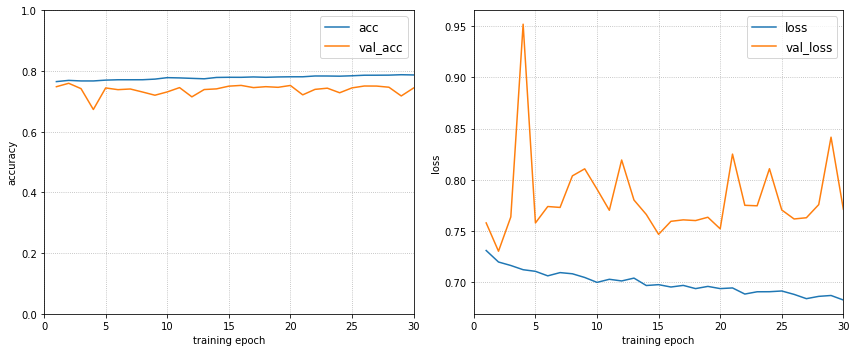

In [63]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['accuracy'], label='acc')
ax.plot(epochs, hist.history['val_accuracy'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout()
plt.savefig('b{}_e{}_accuracy.png'.format(batch, epoch))

### ROC Curve and Precision-Recall

Plot both the ROC curves per class and the class-averaged ROC curve.

In [64]:
y_pred = model.predict(x_test)

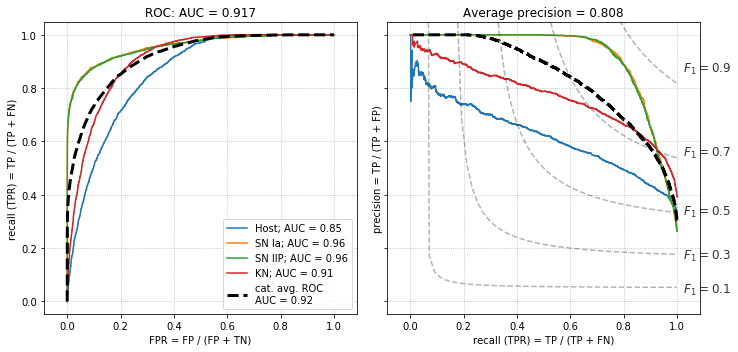

In [65]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()
plt.savefig('b{}_e{}_metrics.png'.format(batch, epoch))

### Confusion Matrix

In [66]:
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

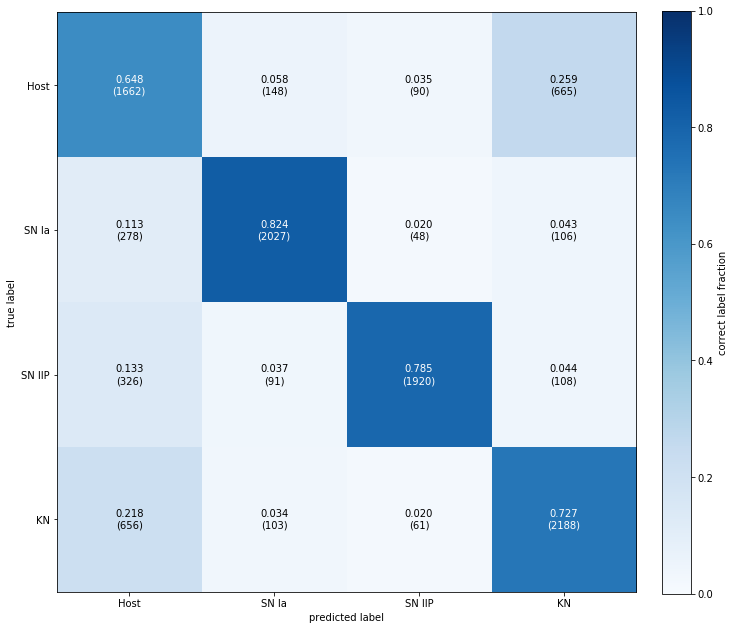

In [67]:
fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()
plt.savefig('b{}_e{}_matrix.png'.format(batch, epoch))

In [51]:
model.save('b{}_e{}_3label'.format(batch, epoch))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: 3label_cnn_restframe/assets


In [52]:
model.save('b{}_e{}_3label.h5'.format(batch, epoch))